## Weather Data S2 Cell Mapping

In [118]:
import s2_py as s2
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil import rrule
import matplotlib.pyplot as plt
from functools import reduce
import shapefile as shp
import geopandas as gpd
import descartes
from shapely.geometry import Polygon, mapping, Point
from sklearn.metrics.pairwise import euclidean_distances

In [27]:
weather_data_file = "/home/s2/weather_201701010000.csv"
cal_shape_file = "/home/s2/CA_S2Cells_centroids.shp"

In [28]:
ca_df = gpd.read_file(cal_shape_file)
crs = {'init': 'epsg:4326'}
ca_df = ca_df.to_crs(crs)

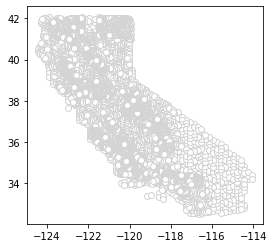

In [29]:
ca_df.plot(color='white', edgecolor='lightgrey')

In [30]:
ca_df.head()

,CWA,NAME,STATE_ZONE,FE_AREA,AREA,WF_cum_are,FZ_grp,S2_Cells_I,geometry
0,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8a4,POINT (-116.8910062173898 36.87155245914239)
1,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8ac,POINT (-117.0793794721554 36.82552116397655)
2,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80b8b4,POINT (-117.0793796132071 36.98512533455602)
3,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be44,POINT (-118.2058442001594 37.3352638859018)
4,VEF,Death Valley National Park,CA227,ee,2.001602,37.487592,low,80be4c,POINT (-118.20584405509 37.17744937398349)


In [31]:
parse_dates = ['date']
weather_df = pd.read_csv(weather_data_file, parse_dates=parse_dates)

In [32]:
weather_df.head()

,date,air_temp_max,air_temp_min,air_temp_mean,precip_accum_max,relative_humidity_max,relative_humidity_min,relative_humidity_mean,wind_speed_max,wind_speed_min,wind_speed_mean,wind_gust_max,name,ID,stid,elevation,latitude,longitude
0,2017-01-01,1.0,-11.0,-5.413043,NaN,100.0,68.56,88.021037,7.72,0.0,1.508136,9.77,Alturas,82,KAAT,4383.0,41.48362,-120.5615
1,2017-01-02,-2.0,-12.0,-5.735736,NaN,100.0,63.45,88.740060,9.26,0.0,2.378532,12.86,Alturas,82,KAAT,4383.0,41.48362,-120.5615
2,2017-01-03,1.0,-7.0,-3.864350,NaN,100.0,80.19,91.784653,5.14,0.0,1.224320,NaN,Alturas,82,KAAT,4383.0,41.48362,-120.5615
3,2017-01-04,1.1,-7.0,-1.174224,NaN,100.0,73.84,91.926708,8.75,0.0,2.675994,11.32,Alturas,82,KAAT,4383.0,41.48362,-120.5615
4,2017-01-05,-6.0,-29.0,-19.204319,NaN,100.0,75.06,86.336567,2.57,0.0,0.670497,NaN,Alturas,82,KAAT,4383.0,41.48362,-120.5615


In [72]:
list(ca_df.columns)

['CWA',
 'NAME',
 'STATE_ZONE',
 'FE_AREA',
 'AREA',
 'WF_cum_are',
 'FZ_grp',
 'S2_Cells_I',
 'geometry']

In [122]:
# Given a subset of columns of weather data (eg air temp, precipitation...) 
# determine the closest weather station to the S2 cell centroid
# return the station id and the weather
# Adapted from code written by Nick Conidas
def closest_station(weather_slice, s2_centroids):
    # array of x,y coords of each measurement station
    X = weather_slice[['longitude','latitude']].values
    # array of x,y coords of each s2 cell
    Y = np.array(s2_centroids['geometry'].apply(lambda x : np.array([x.x,x.y])))
    # calculate the nearest weather station and return weather data without lat/long
    result = weather_slice.iloc[euclidean_distances(np.stack(X),np.stack(Y)).argmin(axis=0)].drop(['latitude','longitude'], 1).reset_index(drop=True)
    # return the weather data with the S2 cell id
    return result.assign(S2_Cells_ID = s2_centroids.S2_Cells_I)

Iterate by date

  For each type of weather:  
    - Filter out NaN rows    
    - Obtain the closest station    
    - Return the station ID and weather
    
  Merge the weather types by date and cell id
  
  Append to weather_cells dataframe

In [123]:
start = datetime(2017, 1, 1)
end = start + timedelta(days=1)
weather_cells = pd.DataFrame()

# Iterate daily
for dtime in rrule.rrule(rrule.DAILY, dtstart=start, until=end):
    strdtime = dtime.strftime("%Y%m%d%H%M")
    
    # Air temperature
    air_temp_df = weather_df.loc[weather_df['date'] == strdtime, ['date', 'latitude', 'longitude', 'stid', 'air_temp_max', 'air_temp_min', 'air_temp_mean']].reset_index(drop=True)
    air_temp_cells = closest_station(air_temp_df.dropna(), ca_df)
    air_temp_cells.rename(columns = {'stid':'stid_air_temp'}, inplace = True)
    
    # Precipitation
    precip_df = weather_df.loc[weather_df['date'] == strdtime, ['date', 'latitude', 'longitude', 'stid', 'precip_accum_max']].reset_index(drop=True)
    precip_cells = closest_station(precip_df.dropna(), ca_df)
    precip_cells.rename(columns = {'stid':'stid_precip'}, inplace = True)

    # Relative humidity
    relative_humidity_df = weather_df.loc[weather_df['date'] == strdtime, ['date', 'latitude', 'longitude', 'stid', 'relative_humidity_max', 'relative_humidity_min', 'relative_humidity_mean']].reset_index(drop=True)
    relative_humidity_cells = closest_station(relative_humidity_df.dropna(), ca_df)
    relative_humidity_cells.rename(columns = {'stid':'stid_relative_humidity'}, inplace = True)

    # Wind_speed
    wind_speed_df = weather_df.loc[weather_df['date'] == strdtime, ['date', 'latitude', 'longitude', 'stid', 'wind_speed_max', 'wind_speed_min', 'wind_speed_mean']].reset_index(drop=True)
    wind_speed_cells = closest_station(wind_speed_df.dropna(), ca_df)
    wind_speed_cells.rename(columns = {'stid':'stid_wind_speed'}, inplace = True)

    # Wind_gust
    wind_gust_df = weather_df.loc[weather_df['date'] == strdtime, ['date', 'latitude', 'longitude', 'stid', 'wind_gust_max']].reset_index(drop=True)
    wind_gust_cells = closest_station(wind_gust_df.dropna(), ca_df)
    wind_gust_cells.rename(columns = {'stid':'stid_wind_gust'}, inplace = True)
    
    # Merge
    data_frames = [air_temp_cells, precip_cells, relative_humidity_cells, wind_speed_cells, wind_gust_cells]
    weather_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date', 'S2_Cells_ID'], how='outer'), data_frames)

    # Append
    weather_cells = weather_cells.append(weather_merged, ignore_index = True)


In [124]:
weather_cells.head()

,date,stid_air_temp,air_temp_max,air_temp_min,air_temp_mean,S2_Cells_ID,stid_precip,precip_accum_max,stid_relative_humidity,relative_humidity_max,relative_humidity_min,relative_humidity_mean,stid_wind_speed,wind_speed_max,wind_speed_min,wind_speed_mean,stid_wind_gust,wind_gust_max
0,2017-01-01,CQ162,15.80,9.00,11.663636,80b8a4,HTRC1,0.254,ISWC1,93.0,51.0,76.250000,CQ162,3.50,1.0,1.977273,ISWC1,3.23
1,2017-01-01,ISWC1,14.83,5.48,10.545243,80b8ac,HTRC1,0.254,ISWC1,93.0,51.0,76.250000,CQ162,3.50,1.0,1.977273,ISWC1,3.23
2,2017-01-01,ISWC1,14.83,5.48,10.545243,80b8b4,HTRC1,0.254,ISWC1,93.0,51.0,76.250000,CQ162,3.50,1.0,1.977273,ISWC1,3.23
3,2017-01-01,A1281,9.91,-5.69,1.397500,80be44,DPSC1,14.732,A1281,89.9,39.9,72.154167,A1281,4.79,0.7,2.386667,E4197,6.26
4,2017-01-01,AN047,9.41,-2.19,2.864167,80be4c,DPSC1,14.732,AN047,82.7,37.7,69.729167,E4197,3.58,0.0,1.147474,E4197,6.26
